# Chapter 2: TensorFlow 2

This notebook reproduces the code and summarizes the theoretical concepts from Chapter 2 of *'TensorFlow in Action'* by Thushan Ganegedara.

This chapter covers the fundamentals of TensorFlow 2, its basic data structures (`tf.Variable`, `tf.Tensor`), core operations (`tf.matmul`, `tf.nn.convolution`), and how it differs from TensorFlow 1 by using eager execution by default.

## 2.1 First steps with TensorFlow 2

This section implements a simple Multilayer Perceptron (MLP), also known as a fully connected network. An MLP consists of an input layer, one or more hidden layers, and an output layer. Each layer's output is computed using the equation $h = \sigma(xW + b)$, where $x$ is the input, $W$ and $b$ are the layer's weights and biases, and $\sigma$ is a non-linear activation function (like sigmoid or ReLU).

In [1]:
import numpy as np
import tensorflow as tf

# 1. Define input and variables
# Input x is a NumPy array
x = np.random.normal(size=[1, 4]).astype('float32')

# Use an initializer for weights
init = tf.keras.initializers.RandomNormal()

# Define model parameters as tf.Variable objects
w1 = tf.Variable(init(shape=[4, 3]))
b1 = tf.Variable(init(shape=[1, 3]))
w2 = tf.Variable(init(shape=[3, 2]))
b2 = tf.Variable(init(shape=[1, 2]))

# 2. Define the forward pass function
# The @tf.function decorator compiles the Python function into a high-performance TensorFlow graph.
@tf.function
def forward(x, W, b, act):
    # tf.matmul performs matrix multiplication
    return act(tf.matmul(x, W) + b)

# 3. Execute the model's forward pass
# Compute the hidden layer output 'h' using sigmoid activation
h = forward(x, w1, b1, tf.nn.sigmoid)

# Compute the final output 'y' using softmax activation
# Softmax normalizes the output into a probability distribution
y = forward(h, w2, b2, tf.nn.softmax)

print("Input:")
print(x)
print("\nHidden Layer Output:")
print(h)
print("\nFinal Output:")
print(y)

Input:
[[-1.1585734   0.79221946  1.0666294  -0.37187704]]

Hidden Layer Output:
tf.Tensor([[0.5245664 0.4768793 0.4858593]], shape=(1, 3), dtype=float32)

Final Output:
tf.Tensor([[0.48804948 0.51195055]], shape=(1, 2), dtype=float32)


### 2.1.1 How does TensorFlow operate under the hood?

TensorFlow 2 uses **imperative style execution** (also called **eager execution**) by default. This means operations are computed immediately, just like standard Python code, making it easy to debug and iterate.

However, for performance, TensorFlow can convert Python functions into **data-flow graphs** using the **`@tf.function` decorator** (a feature called **AutoGraph**). This graph represents the computations as nodes and the tensors flowing between them as edges. TensorFlow can then optimize this graph and run it efficiently on hardware like GPUs or TPUs.

This contrasts with TensorFlow 1, which used **declarative graph-based execution**. In TF1, you first had to explicitly define the entire graph and then separately execute it within a `Session`.

#### Key Differences: TensorFlow 1 vs. TensorFlow 2

| TensorFlow 1 | TensorFlow 2 |
| :--- | :--- |
| Uses declarative graph execution (Define then Run) | Uses eager execution by default (Define by Run) |
| Requires explicit `Session.run()` calls to execute code | Operations run immediately, like NumPy |
| Must explicitly define the data-flow graph | AutoGraph (`@tf.function`) automatically creates graphs from Python code |
| Debugging is difficult as errors occur inside the graph | Easy to debug using standard Python tools (like `print()` or `pdb`) |
| Code can be non-intuitive and split into graph definition and execution | Code is more readable and follows a standard Python structure |

---

## 2.2 TensorFlow building blocks

There are three major basic elements in TensorFlow 2:
1.  **`tf.Variable`**: Holds mutable (changeable) state, like a model's weights. These are the parameters that get updated during training.
2.  **`tf.Tensor`**: Represents an immutable (unchangeable) $n$-dimensional array. It's the primary data structure, and it's what flows between operations in the graph.
3.  **`tf.Operation`**: A node in the graph that performs a computation (e.g., `tf.matmul`, `tf.add`). It takes `tf.Tensor` objects as input and produces `tf.Tensor` objects as output.

### 2.2.1 Understanding `tf.Variable`

In [2]:
# Creating tf.Variable objects

# From a tf.constant
v1 = tf.Variable(tf.constant(2.0, shape=[4]), dtype='float32')
print("v1:", v1)

# From a NumPy array
v2 = tf.Variable(np.ones(shape=[4, 3]), dtype='float32')
print("\nv2:", v2)

# Using a Keras initializer
v3 = tf.Variable(tf.keras.initializers.RandomNormal()(shape=[3, 4, 5]), dtype='float32')
print("\nv3 shape:", v3.shape)

# Converting a Variable to a NumPy array
arr = v1.numpy()
print("\nv1 as numpy:", arr)

# Modifying a Variable using .assign()
v = tf.Variable(np.zeros(shape=[4, 3]), dtype='float32')
print("\nOriginal v:\n", v.numpy())

# Assign a single element
v[0, 2].assign(1.0)
print("\nAfter v[0, 2].assign(1.0):\n", v.numpy())

# Assign a slice
v[2:, :2].assign(tf.constant([[3.0, 3.0], [3.0, 3.0]]))
print("\nAfter slice assignment:\n", v.numpy())

v1: <tf.Variable 'Variable:0' shape=(4,) dtype=float32, numpy=array([2., 2., 2., 2.], dtype=float32)>

v2: <tf.Variable 'Variable:0' shape=(4, 3) dtype=float32, numpy=
array([[1., 1., 1.],
       [1., 1., 1.],
       [1., 1., 1.],
       [1., 1., 1.]], dtype=float32)>

v3 shape: (3, 4, 5)

v1 as numpy: [2. 2. 2. 2.]

Original v:
 [[0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]

After v[0, 2].assign(1.0):
 [[0. 0. 1.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]

After slice assignment:
 [[0. 0. 1.]
 [0. 0. 0.]
 [3. 3. 0.]
 [3. 3. 0.]]


### 2.2.2 Understanding `tf.Tensor`

In [3]:
# tf.Tensor objects are the immutable outputs of operations

# 'b' is a tf.Tensor (specifically, an EagerTensor)
b = v1 * 3.0
print(f"Type of 'b': {type(b).__name__}")
print(f"Is 'b' a tf.Tensor? {isinstance(b, tf.Tensor)}")

# 'c' is also a tf.Tensor
a = tf.constant(2, shape=[4], dtype='float32')
c = tf.add(a, b)
print(f"\n'c' (a + b): {c.numpy()}")

# Trying to modify a tf.Tensor will raise an error
try:
    c[0].assign(2.0)
except AttributeError as e:
    print(f"\nError when trying to modify a tensor: {e}")

Type of 'b': EagerTensor
Is 'b' a tf.Tensor? True

'c' (a + b): [8. 8. 8. 8.]

Error when trying to modify a tensor: 'tensorflow.python.framework.ops.EagerTensor' object has no attribute 'assign'


### 2.2.3 Understanding `tf.Operation`

In [4]:
# Basic arithmetic operations
a = tf.constant(4, shape=[4], dtype='float32')
b = tf.constant(2, shape=[4], dtype='float32')
print(f"a + b = {(a + b).numpy()}")
print(f"a * b = {(a * b).numpy()}")

# Logical comparisons
a = tf.constant([[1, 2, 3], [4, 5, 6]])
b = tf.constant([[5, 4, 3], [3, 2, 1]])
print(f"\na == b:\n {a == b}")
print(f"\na <= b:\n {a <= b}")

# Reduction operations
a = tf.constant(np.random.normal(size=[5, 4, 3]), dtype='float32')

# Sum of all elements
red_all = tf.reduce_sum(a)
print(f"\nSum of all elements: {red_all.numpy()}")

# Product along axis 0
red_a2 = tf.reduce_prod(a, axis=0)
print(f"\nProduct along axis 0 shape: {red_a2.shape}")

# Minimum over axes 0 and 1
red_a3 = tf.reduce_min(a, axis=[0, 1])
print(f"\nMinimum over axes 0 and 1 shape: {red_a3.shape}")

# Demonstrating keepdims
red_keepdims_false = tf.reduce_min(a, axis=1, keepdims=False)
print(f"\nkeepdims=False shape: {red_keepdims_false.shape}")

red_keepdims_true = tf.reduce_min(a, axis=1, keepdims=True)
print(f"keepdims=True shape: {red_keepdims_true.shape}")

a + b = [6. 6. 6. 6.]
a * b = [8. 8. 8. 8.]

a == b:
 [[False False  True]
 [False False False]]

a <= b:
 [[ True  True  True]
 [False False False]]

Sum of all elements: 4.261592864990234

Product along axis 0 shape: (4, 3)

Minimum over axes 0 and 1 shape: (3,)

keepdims=False shape: (5, 3)
keepdims=True shape: (5, 1, 3)


---

## 2.3 Neural network-related computations in TensorFlow

This section demonstrates core neural network operations using a computer vision example (image manipulation). We'll use the famous 'baboon' image, which requires downloading it first.

In [22]:
import os
from PIL import Image
import requests

# image_url = "https://www.publicdomainpictures.net/pictures/30000/velka/mandrill-baboon-1335017585T6P.jpg" # A different direct link to a baboon image
image_path = "baboon.jpg"

# Always attempt to download the image to ensure it's not corrupted
print("Downloading image...")
r = requests.get(image_url)
r.raise_for_status() # Raise an HTTPError for bad responses (4xx or 5xx)
with open(image_path, 'wb') as f:
    f.write(r.content)
print("Image downloaded and overwritten.")

# Resize image to 512x512 as used in the book's example
img = Image.open(image_path)
img = img.resize((512, 512))
img.save(image_path) # Save the resized image

print(f"Image resized to {img.size}")

HTTPError: 403 Client Error: Forbidden for url: https://www.publicdomainpictures.net/pictures/30000/velka/mandrill-baboon-1335017585T6P.jpg

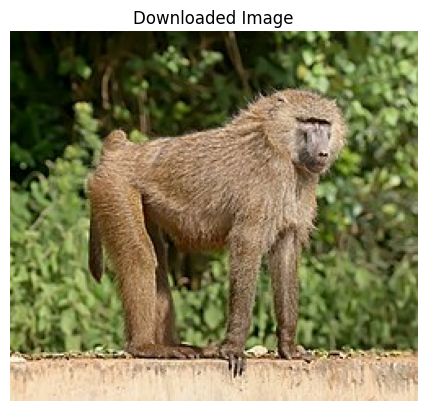

In [23]:
import matplotlib.pyplot as plt
from PIL import Image

image_path = "baboon.jpg"

# Load the image
img = Image.open(image_path)

# Display the image
plt.imshow(img)
plt.title("Downloaded Image")
plt.axis('off') # Hide axes ticks
plt.show()

### 2.3.1 Matrix Multiplication (RGB to Grayscale)

We can convert an RGB image (shape `[H, W, 3]`) to grayscale (shape `[H, W, 1]`) by performing a matrix multiplication with a weights vector `[0.3], [0.59], [0.11]`. `tf.squeeze` is used to remove the last dimension of size 1.

Original shape: (512, 512, 3)
Grayscale shape before squeeze: (512, 512, 1)
Grayscale shape after squeeze: (512, 512)


Text(0.5, 1.0, 'Grayscale Image')

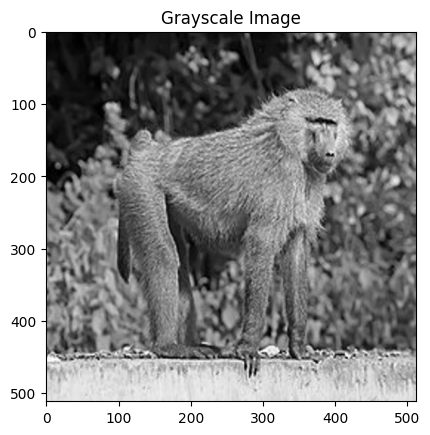

In [30]:
# Load the RGB image
img = Image.open(image_path)

# Ensure the image is 512x512 before converting to NumPy array
img_resized = img.resize((512, 512))
x_rgb = np.array(img_resized).astype('float32')

# Convert NumPy array to tf.Tensor
x_rgb_tf = tf.constant(x_rgb)

# Define the RGB-to-grayscale conversion weights
grays = tf.constant([[0.3], [0.59], [0.11]], dtype='float32')

# Perform matrix multiplication
x_gray = tf.matmul(x_rgb_tf, grays)

# Remove the last dimension (of size 1)
x_gray_squeezed = tf.squeeze(x_gray)

print(f"Original shape: {x_rgb_tf.shape}")
print(f"Grayscale shape before squeeze: {x_gray.shape}")
print(f"Grayscale shape after squeeze: {x_gray_squeezed.shape}")

plt.imshow(x_gray_squeezed, cmap='gray')
plt.title("Grayscale Image")

### 2.3.2 Convolution Operation (Edge Detection)

The convolution operation (`tf.nn.convolution`) is fundamental to CNNs. It slides a small window (filter or kernel) over the data, performing element-wise multiplications and summing the results. We can use it for effects like edge detection.

Note: `tf.nn.convolution` expects 4D tensors: `[batch, height, width, channels]`.

Input shape: (1, 512, 512, 1)
Filter shape: (3, 3, 1, 1)
Convolution output shape: (1, 510, 510, 1)


Text(0.5, 1.0, 'Edge Detected Image')

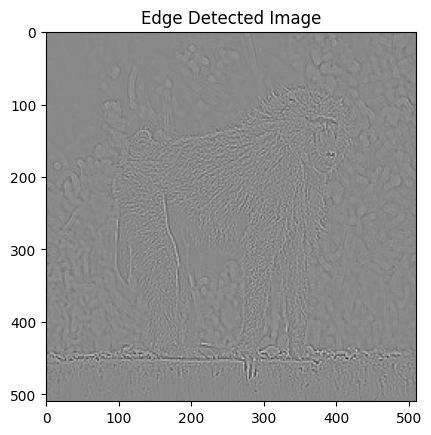

In [31]:
# Use the squeezed grayscale image from the previous step
y = tf.constant(x_gray_squeezed)

# Define an edge detection filter (Laplacian filter)
filter_val = np.array([[-1, -1, -1], [-1, 8, -1], [-1, -1, -1]]).astype('float32')
edge_filter = tf.Variable(filter_val)

# Reshape input and filter to 4D for tf.nn.convolution
# Input shape: [1, 512, 512, 1]
y_reshaped = tf.reshape(y, [1, 512, 512, 1])

# Filter shape: [3, 3, 1, 1]
filter_reshaped = tf.reshape(edge_filter, [3, 3, 1, 1])

# Perform convolution
y_conv = tf.nn.convolution(y_reshaped, filter_reshaped)

print(f"Input shape: {y_reshaped.shape}")
print(f"Filter shape: {filter_reshaped.shape}")
print(f"Convolution output shape: {y_conv.shape}") # Output is 510x510 due to 'valid' padding by default

plt.imshow(tf.squeeze(y_conv), cmap='gray')
plt.title("Edge Detected Image")

### 2.3.3 Pooling Operation (Resizing)

Pooling (`tf.nn.max_pool` or `tf.nn.avg_pool`) is used to downsample or resize feature maps, making the network more translation-invariant. It slides a window and takes either the maximum or average value from that window.

Input shape: (1, 510, 510, 1)
Avg Pool output shape: (1, 255, 255, 1)
Max Pool output shape: (1, 255, 255, 1)

Squeezed Max Pool shape: (255, 255)


Text(0.5, 1.0, 'Max Pool Image')

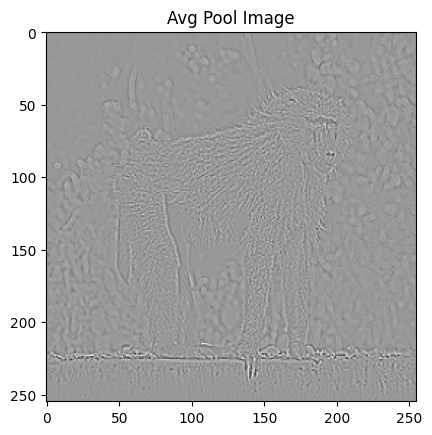

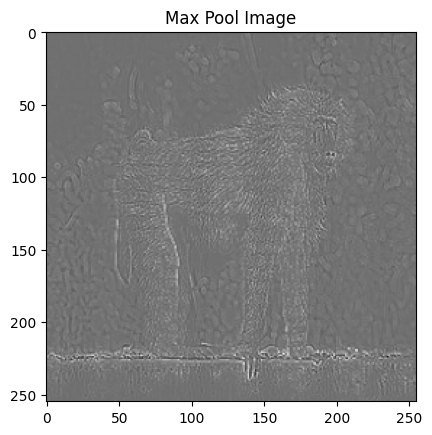

In [33]:
# Use the convolution output from the previous step
# Note: The book uses y_conv, which is 510x510. We'll use that.

# ksize: The size of the pooling window [batch, height, width, channels]
# strides: How much to move the window [batch, height, width, channels]
ksize = [1, 2, 2, 1]
strides = [1, 2, 2, 1]

# Perform average pooling
z_avg = tf.nn.avg_pool(y_conv, ksize=ksize, strides=strides, padding='VALID')

# Perform max pooling
z_max = tf.nn.max_pool(y_conv, ksize=ksize, strides=strides, padding='VALID')

print(f"Input shape: {y_conv.shape}")
print(f"Avg Pool output shape: {z_avg.shape}")
print(f"Max Pool output shape: {z_max.shape}")

# Squeeze to visualize
z_avg_squeezed = tf.squeeze(z_avg)
z_max_squeezed = tf.squeeze(z_max)
print(f"\nSqueezed Max Pool shape: {z_max_squeezed.shape}")

plt.imshow(z_avg_squeezed, cmap='gray')
plt.title("Avg Pool Image")

plt.figure()
plt.imshow(z_max_squeezed, cmap='gray')
plt.title("Max Pool Image")